<a href="https://colab.research.google.com/github/ValentinaTosic/RI-project/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from pathlib import Path
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [23]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
!git clone https://github.com/ValentinaTosic/RI-project.git

Cloning into 'RI-project'...
remote: Enumerating objects: 17091, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 17091 (delta 8), reused 3 (delta 0), pack-reused 17068
Receiving objects: 100% (17091/17091), 422.64 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (16763/16763), done.


In [26]:
%cd RI-project/input/100-bird-species/

/content/RI-project/input/100-bird-species/RI-project/input/100-bird-species


In [27]:
train_path = "./train/"
test_path  = "./test/"
val_path = "./valid/"

In [28]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

def load(train):
    if train:
        place = "train"
        transform = train_transform
        dataset = ImageFolder(root=train_path, transform=transform)
    else:
        place = "test"
        transform = test_transform
        dataset = ImageFolder(root=test_path, transform=transform)

    data = DataLoader(dataset, batch_size=32, shuffle=True)

    return data

train = load(train=True)
test = load(train=False)

dataloaders = {
    "train": train,
    "test": test
}

CLASSES = list(test.dataset.class_to_idx.keys())

In [29]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

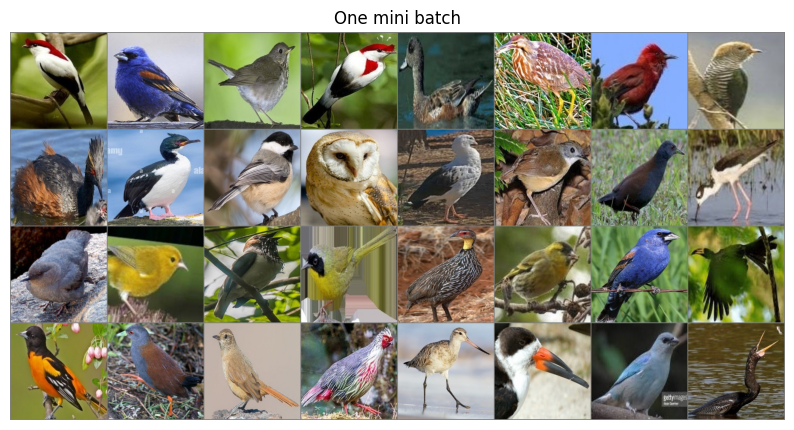

In [30]:
dataiter = iter(train)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [31]:
VGG19 = models.vgg19(pretrained = True)

for param in VGG19.parameters():
    param.requires_grad = False

VGG19

VGG19.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048),
    nn.ReLU(),
    nn.Linear(in_features=2048, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(in_features=512, out_features=100),
    nn.LogSoftmax(dim=1)
)
VGG19 = VGG19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam( VGG19.parameters() , lr = 0.00001)
exp_lr_sc = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
VGG19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [33]:
from torchsummary import summary
summary(VGG19, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [34]:
def accuracy(loader):
    VGG19.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            output = VGG19(x.to(device))
            _, predicted = torch.max(output, 1)
            correct += (predicted == y.to(device)).sum().item()
            total += y.size(0)
    return correct / total

In [35]:
import torch.nn.functional as F

epochs = 7
step = 0
total_loss = 0
train_acc = []
test_acc = []
valid_acc = []

for e in range(epochs):
    for x, y in train:
        VGG19.train()
        optimizer.zero_grad()
        output = VGG19(x.to(device))
        loss = F.nll_loss(output, y.to(device))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        step += 1

        if step % 300 == 0:
            train_acc.append(accuracy(train))
            test_acc.append(accuracy(test))
            print("Epoch:", e+1, "Step:", step, "Loss:", total_loss/300)
            total_loss = 0

            VGG19.eval()
            with torch.no_grad():
              test_accuracy = accuracy(test)
              print("Test Accuracy:", test_accuracy)

            VGG19.train()

Epoch: 1 Step: 300 Loss: 4.1234297490119936
Test Accuracy: 0.572
Epoch: 2 Step: 600 Loss: 2.822670192718506
Test Accuracy: 0.794
Epoch: 2 Step: 900 Loss: 2.0283568759759265
Test Accuracy: 0.872
Epoch: 3 Step: 1200 Loss: 1.572364919781685
Test Accuracy: 0.896
Epoch: 4 Step: 1500 Loss: 1.327743706703186
Test Accuracy: 0.916
Epoch: 4 Step: 1800 Loss: 1.1127227675914764
Test Accuracy: 0.914
Epoch: 5 Step: 2100 Loss: 0.9873341811696689
Test Accuracy: 0.938
Epoch: 5 Step: 2400 Loss: 0.8678135692079862
Test Accuracy: 0.944
Epoch: 6 Step: 2700 Loss: 0.7655240209897359
Test Accuracy: 0.942
Epoch: 7 Step: 3000 Loss: 0.7106464616457622
Test Accuracy: 0.94
Epoch: 7 Step: 3300 Loss: 0.6383654770751794
Test Accuracy: 0.952


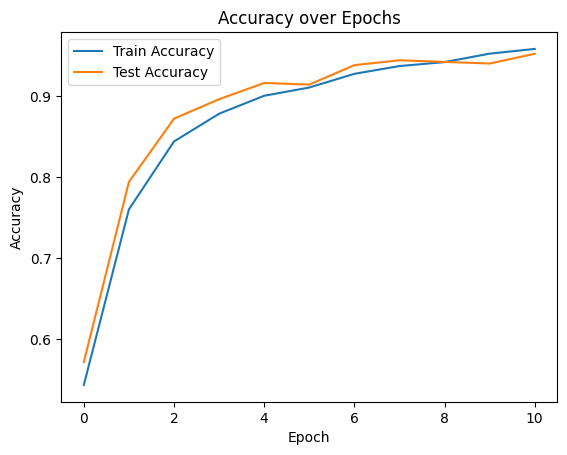

In [40]:
plt.plot(range(len(train_acc)), train_acc, label='Train Accuracy')
plt.plot(range(len(test_acc)), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [38]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))


    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)

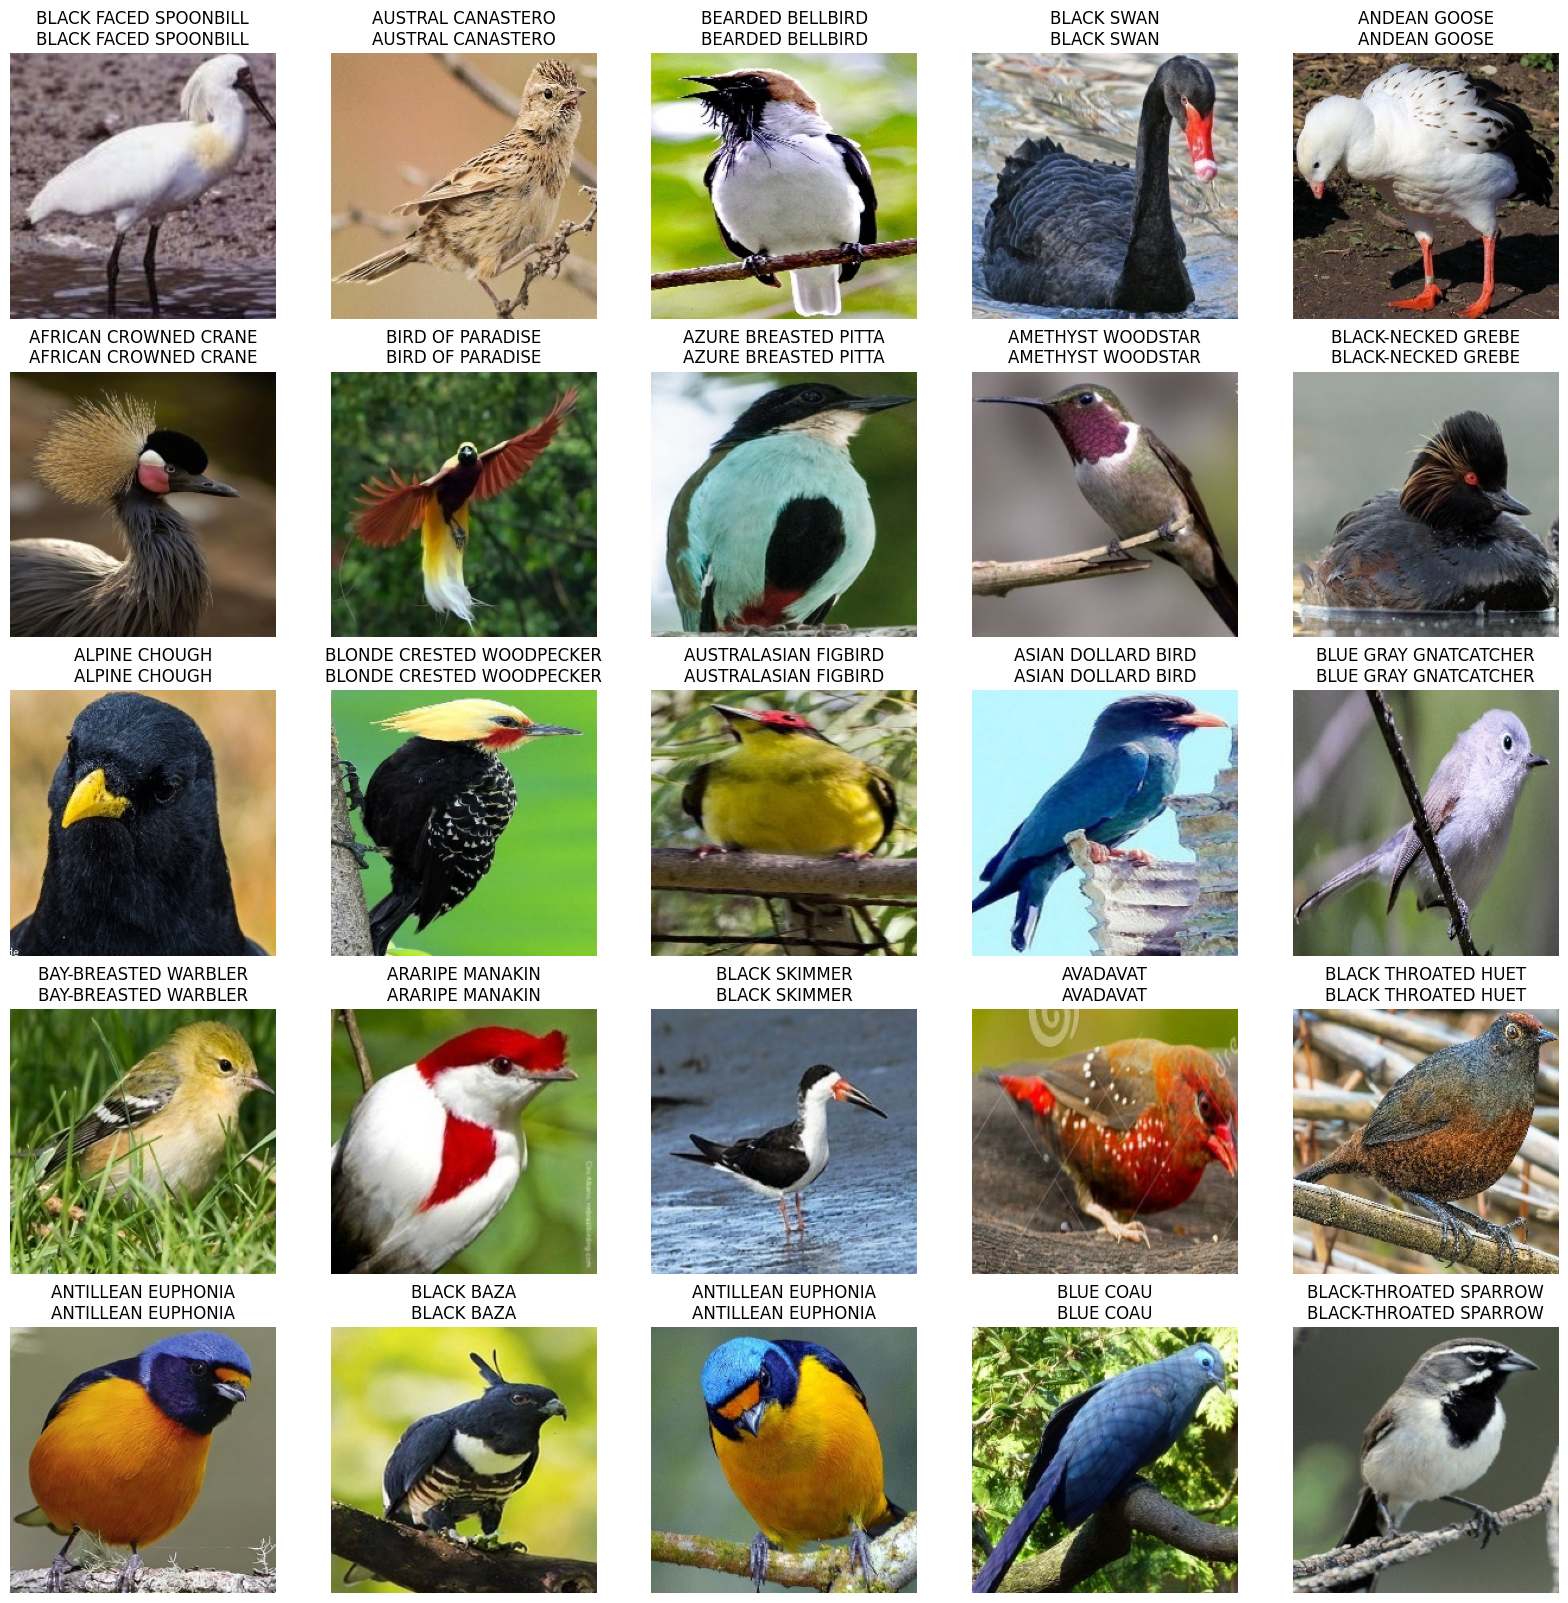

In [39]:
vis_model(VGG19)